# Current Rectification

This notebook focuses mostly on extracting an I-V curve from generated rectified charge data. Mostly focuses on the processes that it took to confirm that a polynomial could accurately achieve the desired information and the generalization of this process.

**Note**: this notebook is to be ran in chronological order

Possible Improvements: Creating a generalizable even/odd order function for n given integers (instead of the odd and even functions used in this notebook). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import curve_fit
import math
import time
sns.set()
%matplotlib inline

In [2]:
def fourier(t, func):
    freq = np.arange(-1/(abs(t[0])-abs(t[1]))/2, 1/(abs(t[0])-abs(t[1]))/2 , 1/(t[-1]-t[0]))
    ft = np.fft.fft(func)
    ftshift = np.fft.fftshift(ft)
    return np.array([freq, ft, ftshift])

def Efield(t, E0 = 1, w=2*np.pi*0.8, s = 0.4 , phi = 0 ):
    return E0*np.sin(w*t+phi)*np.exp(-0.5*(t)**2/s**2) # sin*gaussian

In [3]:
## Generate current class ##

class current():
    
    # initialize current types and variables # 
    
    def __init__(self, height1=1, squeeze1=1, pos1=0, height2=1, squeeze2=1, pos2=0, shift=0, 
                 phi_t=8.01088e-19, phi_s=8.01088e-19, z = 0.5e-9, A=1e-9, 
                 erf=False, ohm=False, cubic=False, exp=False, double_erf=False, step=False, Simmons=False):
        self.height1 = height1
        self.squeeze1 = squeeze1
        self.pos1 = pos1
        self.height2 = height2
        self.squeeze2 = squeeze2
        self.pos2 = pos2
        self.shift = shift
        self.phi_t = phi_t
        self.phi_s = phi_s
        self.z = z
        self.A = A
        
        
        self.erf = erf
        self.ohm = ohm
        self.cubic = cubic
        self.exp = exp
        self.double_erf = double_erf
        self.step = step
        self.Simmons = Simmons
        
    # Call calculate to generate I[V(t)] #  
        
    def calculate(self, V):
        if self.erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.shift
        if self.double_erf == True:
            calculate = self.height1*special.erf((V-self.pos1)*self.squeeze1) + self.height2*special.erf((V - self.pos2)*self.squeeze2) + self.shift
        if self.cubic == True:
            calculate = self.height1*(V*self.squeeze1 - self.pos1)**3 + self.height2*(V*self.squeeze2 - self.pos2) + self.shift
        if self.step == True:
            calculate = self.height1 * (V > self.pos1)
        if self.ohm == True:
            calculate = (V - self.pos1)/self.height1 + self.shift
        if self.exp == True:
            calculate = self.height1*np.exp(-(V*self.squeeze1 - self.pos1)) + self.shift
        if self.Simmons == True:

            I = []
            
            for i in range(0,len(V)):
                

                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < self.phi_s:
                    phi_bar = (self.phi_t+self.phi_s-abs(V[i])*1.60217662e-19)/2
                    delta = self.z
                   

                if V[i]*1.60217662e-19 >= self.phi_s:
                    phi_bar = self.phi_t/2
                    delta = self.z*self.phi_t/(self.phi_t-self.phi_s+abs(V[i])*1.60217662e-19)
                    beta = 23/24
                

                if V[i]*1.60217662e-19 <= -self.phi_t:
                    phi_bar = self.phi_s/2
                    delta = self.z*self.phi_s/(self.phi_s-self.phi_t+abs(V[i])*1.60217662e-19)
                    beta = 23/24
                   

                if V[i]*1.60217662e-19 >= 0 and V[i]*1.60217662e-19 < self.phi_s:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19-self.phi_s+self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                
                if V[i]*1.60217662e-19 > -self.phi_t and V[i]*1.60217662e-19 < 0:
                    beta = 1-1/24*((abs(V[i])*1.60217662e-19+self.phi_s-self.phi_t)/(abs(V[i])*1.60217662e-19-self.phi_s-self.phi_t))**2
                  

                if V[i] >= 0:
                    I.append(1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
               
             

                if V[i] < 0: 
                    I.append(-1.60217662e-19*self.A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                        phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                        -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                           *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
                
            
            calculate = np.asarray(I)

           
    
        else:
            pass
        
        return calculate

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


'Demonstrates how to use the current class and also defines the V(t) for the entire notebook'

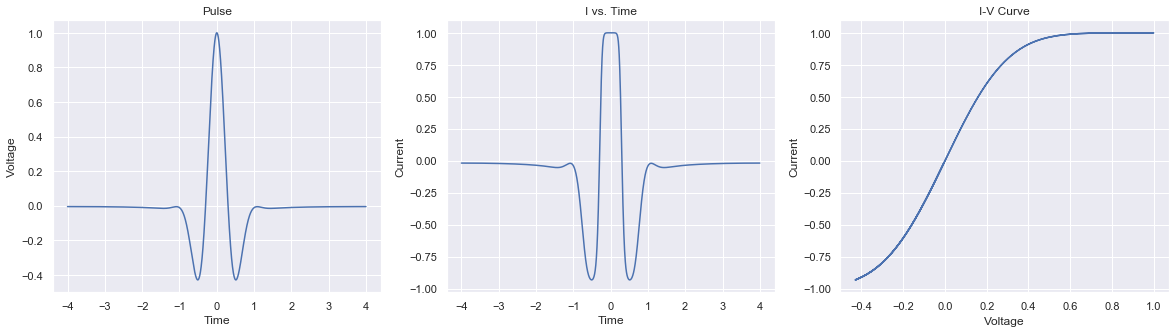

In [4]:
## Make pulse with cosine-like phase ##

t = np.linspace(-4,4,2002)
ft = fourier(t , func = Efield(t))
amp = np.abs(ft[1])

phi = np.zeros(len(ft[0]))  # make array filled with zeros

# #### Uncomment to change phase ####

# for i in range(-1001,1001):      # fill array with values
#     if i >= 0:
#         phi[i] = -np.pi/2
#     if i < 0:
#         phi[i] = np.pi/2

        
pulse = np.fft.ifft(amp*np.exp(1j*phi)) # invFFT signal with new phase
signal = []  # make empty list

for i in range(1001,2002):  # invFFT gives signal shifted, but inFFTshift won't work; this is a manual shift
    signal.append(pulse[i])
    
for i in range(0,1001):
    signal.append(pulse[i])
    
signal = np.asarray(signal)/max(abs(pulse)) # this defines signal for the whole notebook

I = current(height1 = 1, pos1 = 0, squeeze1 = 3, erf = True)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))

ax1.plot(t,signal)
ax1.set_title("Pulse")
ax1.set_xlabel("Time")
ax1.set_ylabel("Voltage")

ax2.plot(t, I.calculate(signal))
ax2.set_title("I vs. Time")
ax2.set_ylabel("Current")
ax2.set_xlabel("Time")

ax3.plot(signal, I.calculate(signal))
ax3.set_title("I-V Curve")
ax3.set_ylabel("Current")
ax3.set_xlabel("Voltage")


"""Demonstrates how to use the current class and also defines the V(t) for the entire notebook"""

## Confirming Fit Works With Basic Case

In order to confirm that a polynomial fit could be done, the most basic case was tested. Basic Demonstration of the algorithm

In [5]:
def cube(V,A):
    return A*V**3

In [6]:
I = current(height1 = 1, pos1 = 0, shift = 0, squeeze1 = 1, squeeze2 = 0, height2 = 0, cubic = True)
sweep_pts = 2002
t = np.linspace(-4,4,sweep_pts)
E0 = np.linspace(0,3,sweep_pts)
pos_sweep = []
neg_sweep = []

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*signal))) # probe negative portion

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

even_order = (pos_sweep+neg_sweep)/2
odd_order = (pos_sweep-neg_sweep)/2



C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


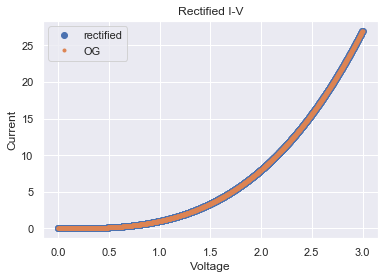

In [7]:
popt1, pcov1 = curve_fit(f = cube, xdata=E0 , 
                       ydata = np.real(odd_order))

rec_current = popt1[0]/integrate.simps(y=signal**3,x=t)*E0**3

plt.title("Rectified I-V")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(E0,rec_current, 'o', label="rectified")
plt.plot(E0, I.calculate(E0), '.', label = "OG")
plt.legend()

## More Complex I-V Curves

### Double Erf

Trying to  fit a polynomial to a double error function I-V curve. 

In [8]:
# """This large polynomial is used for the double erf I-V only"""

# def even(V,A_2=1,A_4=1,A_6=1,A_8=1,A_10=1,A_12=1,A_14=1,A_16=1,A_18=1,A_20=1,A_22=1,A_24=1,A_26=1,A_28=1,A_30=1,A_32=1,A_34=1,A_36=1,A_38=1,A_40=1,A_42=1):
#     return A_2*V**2+A_4*V**4+A_6*V**6+A_8*V**8+A_10*V**10+A_12*V**12+A_14*V**14+A_16*V**16+A_18*V**18+A_20*V**20+A_22*V**22++A_24*V**24+A_26*V**26+A_28*V**28+A_30*V**30+A_32*V**32+A_34*V**34+A_36*V**36+A_38*V**38+A_40*V**40+A_42*V**42



# def odd(V,A_3=1,A_5=1,A_7=1,A_9=1,A_11=1,A_13=1,A_15=1,A_17=1,A_19=1,A_21=1,A_23=1,A_25=1,A_27=1,A_29=1,A_31=1,A_33=1,A_35=1,A_37=1,A_39=1,A_41=1,A_43=1):
#     return A_3*V**3+A_5*V**5+A_7*V**7+A_9*V**9+A_11*V**11+A_13*V**13+A_15*V**15+A_17*V**17+A_19*V**19+A_21*V**21+A_23*V**23+A_25*V**25+A_27*V**27+A_29*V**29+A_31*V**31+A_33*V**33+A_35*V**35+A_37*V**37+A_39*V**39+A_41*V**41+A_43*V**43


####### Apparently this doesn't even work well for a double erf ########

In [9]:
def even(V,A_2=1,A_4=1,A_6=1,A_8=1,A_10=1,A_12=1,A_14=1,A_16=1,A_18=1,A_20=1,A_22=1,A_24=1):
    return A_2*V**2+A_4*V**4+A_6*V**6+A_8*V**8+A_10*V**10+A_12*V**12+A_14*V**14+A_16*V**16+A_18*V**18+A_20*V**20+A_22*V**22++A_24*V**24


def odd(V,A_3=1,A_5=1,A_7=1,A_9=1,A_11=1,A_13=1,A_15=1,A_17=1,A_19=1,A_21=1,A_23=1,A_25=1):
    return A_3*V**3+A_5*V**5+A_7*V**7+A_9*V**9+A_11*V**11+A_13*V**13+A_15*V**15+A_17*V**17+A_19*V**19+A_21*V**21+A_23*V**23+A_25*V**25





In [10]:
"""This cell generates the rectified charge data"""

I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 10,squeeze2 = 10, double_erf = True) # define current
sweep_pts = 2002
t = np.linspace(-4,4,sweep_pts)
E0 = np.linspace(0,3,sweep_pts) 
pos_sweep = []
neg_sweep = []

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*signal))) # probe negative portion

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

even_order = (pos_sweep+neg_sweep)/2 
odd_order = (pos_sweep-neg_sweep)/2

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


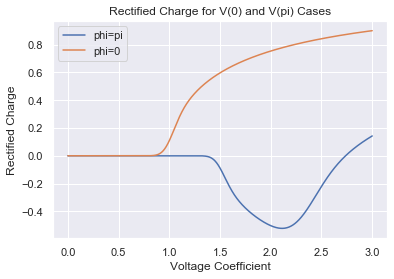

In [11]:
plt.plot(E0,neg_sweep, label = 'phi=pi')
plt.plot(E0,pos_sweep, label = 'phi=0')
plt.title("Rectified Charge for V(0) and V(pi) Cases")
plt.xlabel('Voltage Coefficient')
plt.ylabel('Rectified Charge')
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Rectified Charge')

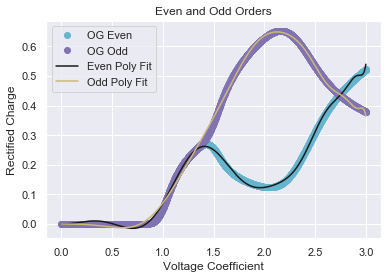

In [12]:
"""This cell fits the even and odd ordered terms of the simulated rectified charge data"""

E0 = np.linspace(0,3,sweep_pts)

popt1, pcov1 = curve_fit(f = even, xdata=E0 ,        # fits the even ordered data using scipy curvefit
                       ydata = np.real(even_order)) 


popt2, pcov2 = curve_fit(f = odd, xdata=E0 ,        # fits odd ordered data
                       ydata = np.real(odd_order))



plt.plot(E0, even_order, 'co', label='OG Even')
plt.plot(E0, odd_order, 'mo', label='OG Odd')
plt.plot(E0, even(E0, *popt1), 'k-', label="Even Poly Fit")
plt.plot(E0, odd(E0, *popt2), 'y-', label="Odd Poly Fit")
plt.legend()
plt.title("Even and Odd Orders")
plt.xlabel("Voltage Coefficient")
plt.ylabel("Rectified Charge")


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


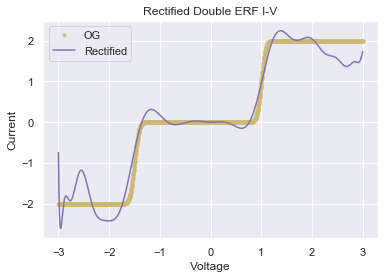

In [13]:
"""This cell calculates the polynomial fit of the current and reconstructs the I-V curve from the fit 
coefficients."""

a_n = []
rec_current = []
E0 = np.linspace(-3,3,2002) ## E0 gets redefined here to be both positive and negative ([-3,3] instead of [0,3]).
                            ## Although it is inconsistent, it saves me from doing 2 loops.
                        


for i in range(0,len(popt1)):
    a_n.append(popt1[i]/integrate.simps(signal**(2*i+2),x=t)) 
    a_n.append(popt2[i]/integrate.simps(signal**(2*i+3),x=t))

a_n = np.asarray(a_n)

for i in range(0,len(a_n)):
    rec_current.append(a_n[i]*E0**(i+2))
    

rec_I = np.sum(rec_current, axis = 0)  ## sums each a_n*V^n term together

plt.plot(E0, I.calculate(E0), 'y.', label = "OG")
plt.plot(E0,rec_I,'m-', label='Rectified')
plt.title("Rectified Double ERF I-V")
plt.xlabel("Voltage")
plt.ylabel('Current')
plt.legend()

### Emitted Field

This section focuses on the theoretical emitted field from the junction. Also, the fourier transform of this pulse is taken to see the frequencies present.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Integral of Emitted Field: -2.5671999992482597e-07


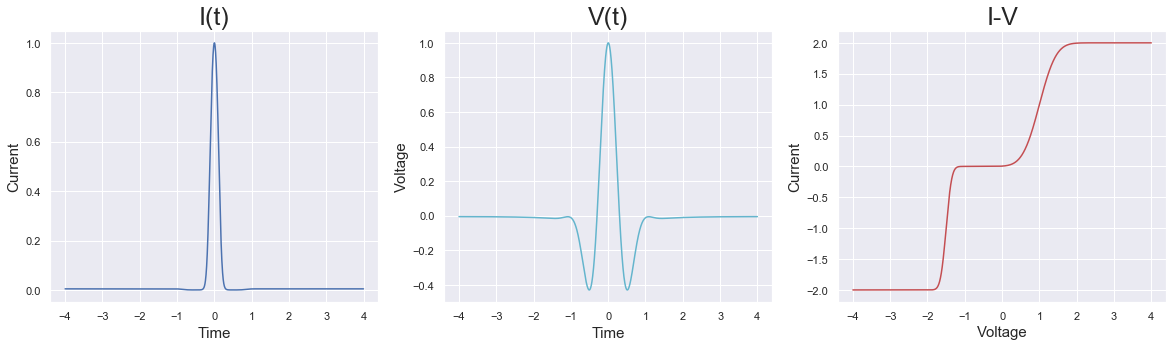

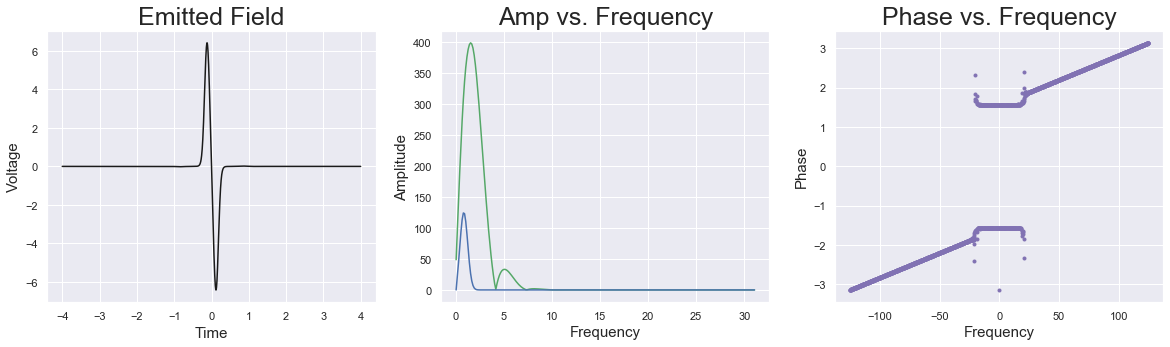

In [16]:
I = current(height1 = 1, pos1 = 1, pos2 = -1.5, shift = 0, squeeze1 = 2,squeeze2 = 6, double_erf = True)
t = np.linspace(-4,4,2002)
sweep_pts = 2002
E0 = np.linspace(0,8,sweep_pts)

pos_sweep = []
neg_sweep = []

ft = fourier(t , func = Efield(t, w = 2*np.pi*0.8, s = 0.4))

## generates Q(V) 

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*signal))) # probe negative portion

IFT = fourier(t,np.diff(I.calculate(signal))/np.diff(t)) ## take FFT of dI/dt (emitted field)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,5))

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

## Plots ##

ax1.plot(t,I.calculate(signal))
ax1.set_title("I(t)",fontsize=25)
ax1.set_xlabel("Time",fontsize=15)
ax1.set_ylabel("Current",fontsize=15)

ax2.plot(t, signal, 'c')
ax2.set_title("V(t)",fontsize=25)
ax2.set_xlabel("Time",fontsize=15)
ax2.set_ylabel("Voltage",fontsize=15)

ax3.plot(np.linspace(-4,4,2002),I.calculate(np.linspace(-4,4,2002)), 'r')
ax3.set_title("I-V",fontsize=25)
ax3.set_xlabel("Voltage",fontsize=15)
ax3.set_ylabel("Current",fontsize=15)

ax4.plot(t[:-1],np.diff(I.calculate(signal))/np.diff(t), 'k')
ax4.set_title("Emitted Field",fontsize=25)
ax4.set_xlabel("Time",fontsize=15)
ax4.set_ylabel("Voltage",fontsize=15)

ax5.plot(IFT[0][1001:1250], np.abs(IFT[2])[1001:1250], 'g')  
ax5.set_title("Amp vs. Frequency", fontsize=25)
ax5.set_xlabel("Frequency",fontsize=15)
ax5.set_ylabel("Amplitude",fontsize=15)
ax5.plot(ft[0][1001:1250], np.abs(ft[2])[1001:1250])  

ax6.plot(IFT[0][:-1], np.angle(IFT[2]), 'm.')
ax6.set_title("Phase vs. Frequency",fontsize=25)
ax6.set_xlabel("Frequency",fontsize=15)
ax6.set_ylabel("Phase",fontsize=15)

print("Integral of Emitted Field:",np.real(integrate.simps(y=np.diff(I.calculate(signal))/np.diff(t))))

### Simmons Model

Simultation of the Simmons Model I-V. Does many of the same operations above but with a more sophisticated model.

In [17]:
def Simmons(V, phi_t=8.01088e-19, phi_s=8.01088e-19, z = 0.5e-9, A=1e9):
    
    I = []
    
    for i in range(0,len(V)):
        
        if V[i]*1.60217662e-19 > -phi_t and V[i]*1.60217662e-19 < phi_s:
            phi_bar = (phi_t+phi_s-abs(V[i])*1.60217662e-19)/2
            delta = z

        if V[i]*1.60217662e-19 >= phi_s:
            phi_bar = phi_t/2
            delta = z*phi_t/(phi_t-phi_s+abs(V[i])*1.60217662e-19)
            beta = 23/24

        if V[i]*1.60217662e-19 <= -phi_t:
            phi_bar = phi_s/2
            delta = z*phi_s/(phi_s-phi_t+abs(V[i])*1.60217662e-19)
            beta = 23/24

        if V[i]*1.60217662e-19 >= 0 and V[i]*1.60217662e-19 < phi_s:
            beta = 1-1/24*((abs(V[i])*1.60217662e-19-phi_s+phi_t)/(abs(V[i])*1.60217662e-19-phi_s-phi_t))**2
            

        if V[i]*1.60217662e-19 > -phi_t and V[i]*1.60217662e-19 < 0:
            beta = 1-1/24*((abs(V[i])*1.60217662e-19+phi_s-phi_t)/(abs(V[i])*1.60217662e-19-phi_s-phi_t))**2
            

        if V[i] >= 0:
            I.append(1.60217662e-19*A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                   *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
  

        if V[i] < 0: 
            I.append(-1.60217662e-19*A/(1.0545718e-34*(2*np.pi*beta*delta)**2)*(
                phi_bar*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2*phi_bar)/1.0545718e-34)
                -(phi_bar+abs(V[i])*1.60217662e-19)*np.exp(-2*beta*delta*np.sqrt(9.10938356e-31*2)
                                                   *np.sqrt(phi_bar+abs(V[i])*1.60217662e-19)/1.0545718e-34)))
     

    return np.array(I)
    

In [18]:
"""This polynomial overfits simple functions but seems to work just fine for the simmons model"""

def even(V,A_2=1,A_4=1,A_6=1,A_8=1,A_10=1,A_12=1,A_14=1,A_16=1,A_18=1,A_20=1,A_22=1,A_24=1):
    return A_2*V**2+A_4*V**4+A_6*V**6+A_8*V**8+A_10*V**10+A_12*V**12+A_14*V**14+A_16*V**16+A_18*V**18+A_20*V**20+A_22*V**22++A_24*V**24


def odd(V,A_3=1,A_5=1,A_7=1,A_9=1,A_11=1,A_13=1,A_15=1,A_17=1,A_19=1,A_21=1,A_23=1,A_25=1):
    return A_3*V**3+A_5*V**5+A_7*V**7+A_9*V**9+A_11*V**11+A_13*V**13+A_15*V**15+A_17*V**17+A_19*V**19+A_21*V**21+A_23*V**23+A_25*V**25




Text(0, 0.5, 'Current')

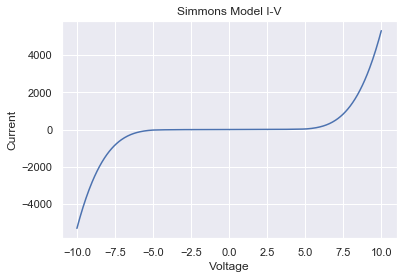

In [19]:
E0 = np.linspace(-10,10,500)
I = current(Simmons = True)
plt.plot(E0,I.calculate(E0),'b')
plt.title("Simmons Model I-V")
plt.xlabel("Voltage")
plt.ylabel("Current")

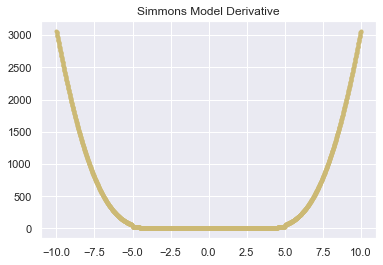

In [20]:
E0 = np.linspace(-10,10,2002)
I = current(Simmons = True)
plt.title("Simmons Model Derivative")
plt.plot(E0[:-1], np.diff(I.calculate(E0))/np.diff(E0), 'y.', label = "OG")

In [21]:
## Generating Q(V) for Simmons Model

I = current(Simmons = True)
sweep_pts = 2002
t = np.linspace(-4,4,sweep_pts)
E0 = np.linspace(0,10,sweep_pts)
pos_sweep = []
neg_sweep = []

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*signal))) # probe negative portion

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

even_order = (pos_sweep+neg_sweep)/2
odd_order = (pos_sweep-neg_sweep)/2



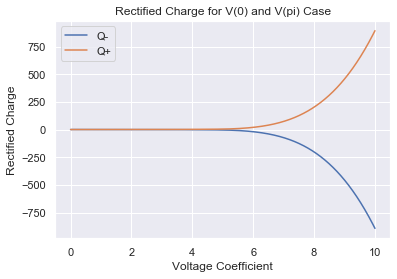

In [22]:
plt.plot(E0, neg_sweep, label = "Q-")
plt.plot(E0, pos_sweep, label = "Q+")
plt.title("Rectified Charge for V(0) and V(pi) Case")
plt.xlabel("Voltage Coefficient")
plt.ylabel("Rectified Charge")
plt.legend()

Text(0, 0.5, 'Rectified Charge')

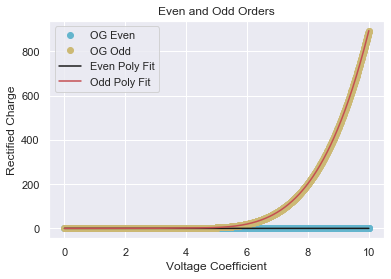

In [23]:
## Poly Fitting Simmons Q(V) ##

popt1, pcov1 = curve_fit(f = even, xdata=E0 , 
                       ydata = np.real(even_order))


popt2, pcov2 = curve_fit(f = odd, xdata=E0 , 
                       ydata = np.real(odd_order))



plt.plot(E0, even_order, 'co', label='OG Even')
plt.plot(E0, odd_order, 'yo', label='OG Odd')
plt.plot(E0, even(E0, *popt1), 'k-', label="Even Poly Fit")
plt.plot(E0, odd(E0, *popt2), 'r-', label="Odd Poly Fit")
plt.legend()
plt.title("Even and Odd Orders")
plt.xlabel("Voltage Coefficient")
plt.ylabel("Rectified Charge")


### Generalizing the Rectification Process

In [24]:
## Generating Q(V) data again ##

E0 = np.linspace(0,8,2002)
t=np.linspace(-4,4,2002)

pos_sweep = []
neg_sweep = []

for i in range(0,sweep_pts):
    pos_sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*signal))) # probe positive portion of I-V
    neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*signal))) # probe negative portion

pos_sweep = np.asarray(pos_sweep)
neg_sweep = np.asarray(neg_sweep)

In [25]:
def rectify(V, E0, t, Q_pos, Q_neg):
    
    """The rectify function takes in experimental values for the input waveform, amplitudes
       (waveform maximums) used in the Q(V) sweep, and the results from the Q[V(0)] and Q[V(pi)] 
       sweeps. It fits a polynomial of order 2 and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform
       E0: Waveform maximums
       t: Time axis
       Q_pos: Q[V(0)] sweep data. Positive cosine wave as a function of waveform maximums
       Q_pos: Q[V(0)] sweep data. Positive cosine wave as a function of waveform maximums"""
    
    a_n = []                
    rec_current = [] 
    I_t = []

    even_order = (Q_pos+Q_neg)/2
    odd_order = (Q_pos-Q_neg)/2
    
    popt1, pcov1 = curve_fit(f = even, xdata=E0 ,   ## fit the even ordered data
                       ydata = np.real(even_order))


    popt2, pcov2 = curve_fit(f = odd, xdata=E0 ,   ## fit the odd ordered data
                       ydata = np.real(odd_order))  


    for i in range(0,len(popt1)):
        a_n.append(popt1[i]/integrate.simps(V**(2*i+2),x=t)) 
        a_n.append(popt2[i]/integrate.simps(V**(2*i+3),x=t))

    a_n = np.asarray(a_n)    
    E0 = np.linspace(-max(E0), max(E0), len(E0)) ## ***Same amount of points but twice as long. Problem?***

    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  ## reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

In [26]:
## Testing rectify Function ##

E0 = np.linspace(0,8,2002)
t=np.linspace(-4,4,2002)

rec = rectify(V=signal, Q_pos = pos_sweep, Q_neg = neg_sweep, E0=E0, t=t) ## call function
rec_I = rec[0]
I_t = rec[1]
a_n = rec[2]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


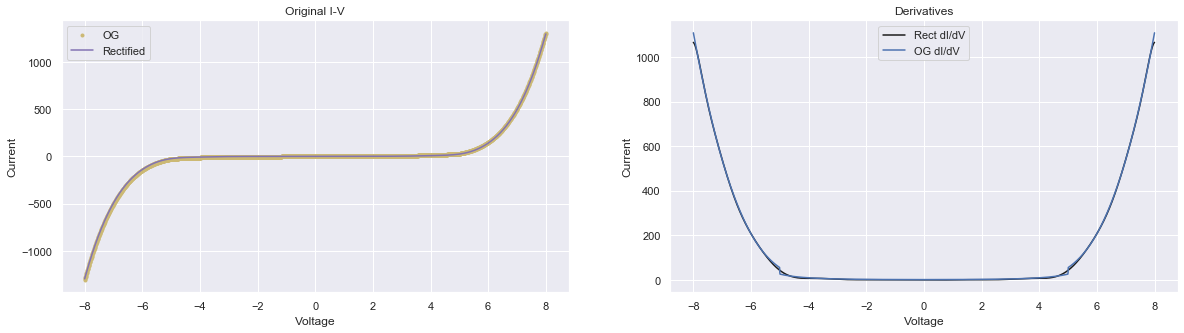

In [27]:
## Plot it ##

E0 = np.linspace(-8,8,2002)
t=np.linspace(-4,4,2002)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(E0,I.calculate(E0), 'y.', label = "OG")
ax1.set_title('Original I-V')
ax1.set_xlabel("Voltage")
ax1.set_ylabel('Current')

ax1.plot(E0,rec_I,'m-', label='Rectified')
ax1.legend()


ax2.plot(E0[:-1], np.diff(rec_I)/np.diff(E0), 'k', label='Rect dI/dV')
ax2.plot(E0[:-1], np.diff(I.calculate(E0))/np.diff(E0), label="OG dI/dV")
ax2.set_title('Derivatives')
ax2.set_xlabel("Voltage")
ax2.set_ylabel('Current')
ax2.legend()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Phase')

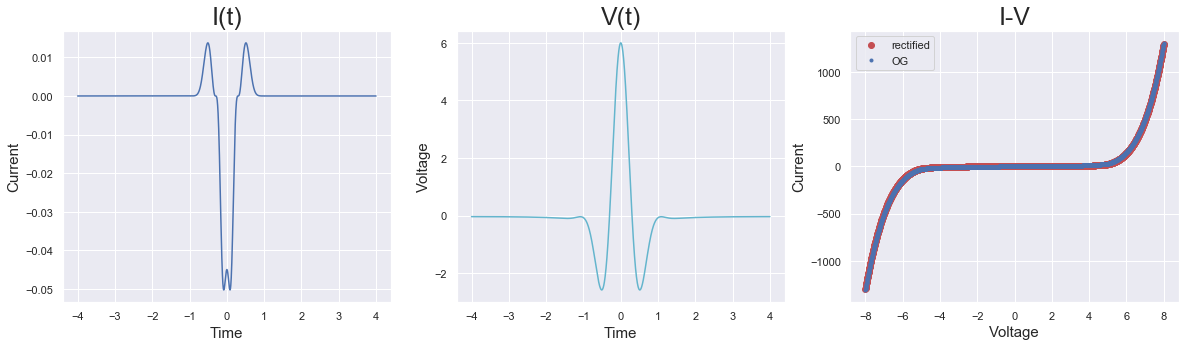

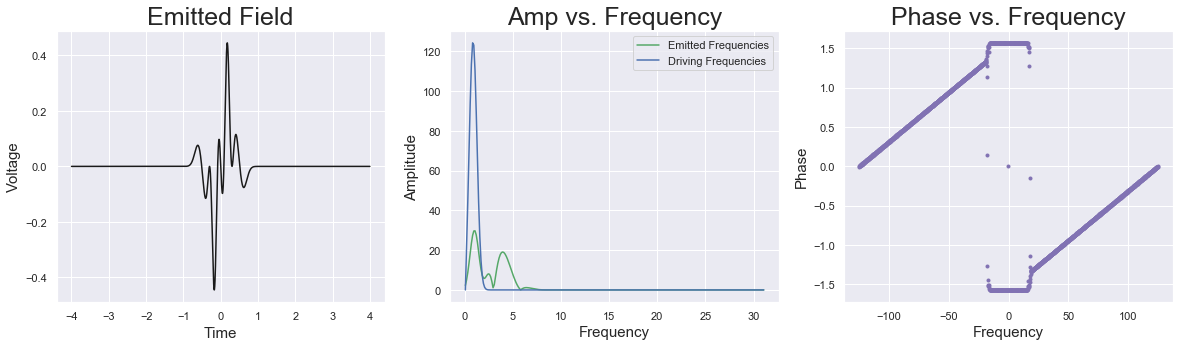

In [28]:
## Find emitted field using rectified I-V ##

t = np.linspace(-4,4,2002)
field = np.linspace(-8,8,2002)
sweep_pts = 2002
pos_sweep = []
neg_sweep = []
norm = Simmons(V=[0.05], A=1e-9)[0]

IFT = fourier(t,np.diff(I_t)/np.diff(t))




fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,5))


ax1.plot(t, I_t)
ax1.set_title("I(t)",fontsize=25)
ax1.set_xlabel("Time",fontsize=15)
ax1.set_ylabel("Current",fontsize=15)

ax2.plot(t, 6*signal, 'c')
ax2.set_title("V(t)",fontsize=25)
ax2.set_xlabel("Time",fontsize=15)
ax2.set_ylabel("Voltage",fontsize=15)

ax3.plot(field,rec_I, 'ro', label = 'rectified')
ax3.plot(field, I.calculate(field), '.', label = 'OG')
ax3.set_title("I-V",fontsize=25)
ax3.set_xlabel("Voltage",fontsize=15)
ax3.set_ylabel("Current",fontsize=15)
ax3.legend()

ax4.plot(t[:-1],np.diff(I_t)/np.diff(t), 'k')
ax4.set_title("Emitted Field",fontsize=25)
ax4.set_xlabel("Time",fontsize=15)
ax4.set_ylabel("Voltage",fontsize=15)

ax5.plot(IFT[0][1001:1250], np.abs(IFT[2])[1001:1250], 'g', label = "Emitted Frequencies")  
ax5.set_title("Amp vs. Frequency", fontsize=25)
ax5.set_xlabel("Frequency",fontsize=15)
ax5.set_ylabel("Amplitude",fontsize=15)
ax5.plot(ft[0][1001:1250], np.abs(ft[2])[1001:1250], label = "Driving Frequencies")
ax5.legend()

ax6.plot(IFT[0][:-1], np.angle(IFT[2]), 'm.')
ax6.set_title("Phase vs. Frequency",fontsize=25)
ax6.set_xlabel("Frequency",fontsize=15)
ax6.set_ylabel("Phase",fontsize=15)


### Current Sweeping

This section explores how I(t) and the emitted field change as a function of driving voltage amplitude

In [29]:
def current_sweep(V, E0, t, a_n, theory = False, rectified = False):
    
    """This function creates a 3D map of I(t), dI/dt, and the emitted field FFT 
        as a function of driving voltage amplitude. You can feed in either a theoretical I-V 
        or an I-V that has been rectified in a previous section."""
    
    if theory == True and rectified == True or theory == False and rectified == False:
        
        return print('Error: Select current type')
      
    
    elif rectified == True:
        
        I_map = np.zeros((len(V),len(E0)))
        Idt_map = np.zeros((len(V), len(E0)-1))
        IFT_map = np.zeros((len(V), len(E0)-1))
        
        
    
        for j in range(0,len(E0)):
            
            I_t = []
            
            for i in range(0,len(a_n)):
                I_t.append(a_n[i]*V**(i+2)*E0[j])
            
            I_t = np.sum(I_t, axis = 0)
            I_dt = np.diff(I_t)/np.diff(t)
            IFT = fourier(t, I_dt)
            
            I_map[j,:] = I_t 
            Idt_map[j,:] = I_dt
            IFT_map[j,:] = np.abs(IFT[2])
            
            
                       
            
    elif theory == True:
        
        I_map = [] 
        Idt_map = []
        IFT_map = []
        
        
        for i in range(0, len(E0)):
            I_map.append(I.calculate(E0[i]*V))
            Idt_map.append(np.diff(I.calculate(E0[i]*V))/np.diff(t))
            IFT = fourier(t, np.diff(I.calculate(E0[i]*V))/np.diff(t))
            IFT_map.append(np.abs(IFT[2]))
        
        I_map = np.asarray(I_map)
        Idt_map = np.asarray(Idt_map)
        IFT_map = np.asarray(IFT_map)
    
      
    
    return [I_map, Idt_map, IFT[0], IFT_map]
                
                


In [30]:
rec_map = current_sweep(V=signal, E0 = E0, t=t, a_n = rec[2], rectified = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


In [31]:
I = current(Simmons = True) ## initialize theoretical current
theory_map = current_sweep(V=signal, E0 = E0, t=t, a_n = rec[2], theory = True)

Text(0, 0.5, 'E0')

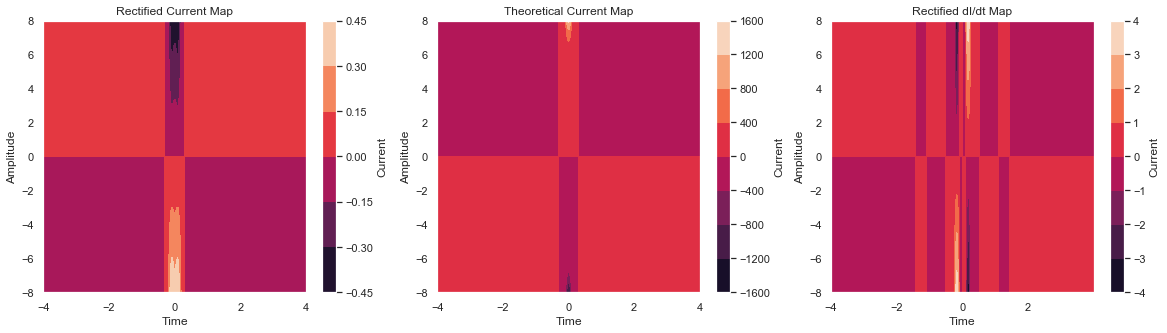

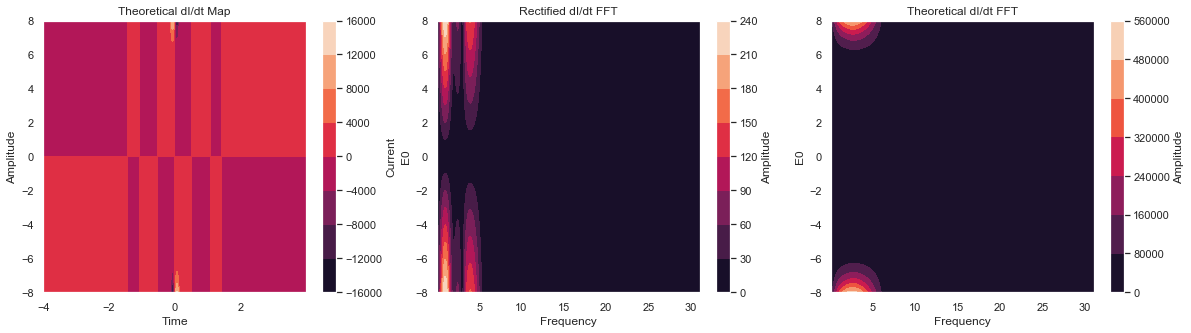

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig, (ax4, ax5, ax6) = plt.subplots(1,3, figsize = (20,5))

cep1 = ax1.contourf(t, E0, rec_map[0]) # contour (color) map 
plt.colorbar(cep1,ax=ax1, label = 'Current') # apply colorbar
ax1.set_title('Rectified Current Map')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')

cep2 = ax2.contourf(t, E0, theory_map[0]) # contour (color) map 
plt.colorbar(cep2, ax=ax2, label = 'Current')# apply colorbar
ax2.set_title('Theoretical Current Map')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

cep3 = ax3.contourf(t[:-1], E0, rec_map[1]) # contour (color) map 
plt.colorbar(cep3, ax=ax3, label = 'Current') # apply colorbar
ax3.set_title('Rectified dI/dt Map')
ax3.set_xlabel('Time')
ax3.set_ylabel('Amplitude')

cep4 = ax4.contourf(t[:-1], E0, theory_map[1]) # contour (color) map 
plt.colorbar(cep4, ax=ax4, label = 'Current') # apply colorbar
ax4.set_title('Theoretical dI/dt Map')
ax4.set_xlabel('Time')
ax4.set_ylabel('Amplitude')

cep5 = ax5.contourf(rec_map[2][1001:1250], E0, rec_map[3][:,1001:1250]) # contour (color) map 
plt.colorbar(cep5, ax=ax5, label = 'Amplitude') # apply colorbar
ax5.set_title('Rectified dI/dt FFT')
ax5.set_xlabel('Frequency')
ax5.set_ylabel('E0')

cep6 = ax6.contourf(theory_map[2][1001:1250], E0, theory_map[3][:,1001:1250]) # contour (color) map 
plt.colorbar(cep6, ax=ax6, label = 'Amplitude') # apply colorbar
ax6.set_title('Theoretical dI/dt FFT')
ax6.set_xlabel('Frequency')
ax6.set_ylabel('E0')





## Try to make rectify function without even/odd orders

In [33]:
def arb_poly(x, *params):
    return sum([p*(x**(i+2)) for i, p in enumerate(params)])

In [34]:
def rectify(V, E0, t, Q, fit_terms):
    
    """The rectify function takes in experimental values for the input waveform, amplitudes
       (waveform maximums and minimums from positive and negative sweeps respectively), and the 
       results from the Q[V(phi=0)] and Q[V(phi=pi)] sweeps. It fits a polynomial of order 2 
       and above to any data and reconstructs an I-V curve.
       
       ***PARAMETERS***
       
       V: Waveform.
       pos_E0: Waveform maximums from sweep using V(phi=0).
       neg_E0: Waveform minimums from sweep using V(phi=pi).
       t: Waveform time domain.
       Q_pos: Q[V(phi=0)] sweep data. Positive cosine wave as a function of waveform maximums.
       Q_neg: Q[V(phi=pi)] sweep data. Negative cosine wave as a function of waveform maximums.
       
       """
    
    a_n = []                
    rec_current = [] 
    I_t = []

#     even_order = (Q_pos+Q_neg)/2
#     odd_order = (Q_pos-Q_neg)/2
    
    popt1, pcov1 = curve_fit(f = arb_poly, xdata=E0 ,   # fit the even ordered data
                       ydata = np.real(Q), p0=[1]*(fit_terms)) # default initial guess to be 1


#     popt2, pcov2 = curve_fit(f = arb_odd_poly, xdata=pos_E0 ,   # fit the odd ordered data
#                        ydata = np.real(odd_order), p0=[1]*(fit_terms))  # default initial guess to be 1


    for i in range(0,len(popt1)):
        a_n.append(popt1[i]/integrate.simps(V**(i+2),x=t)) 

    a_n = np.asarray(a_n)    

    
    for i in range(0,len(a_n)):
        rec_current.append(a_n[i]*E0**(i+2))  # reconstruct current
        I_t.append(a_n[i]*V**(i+2))
 
    rec_I = np.sum(rec_current, axis = 0)
    I_t = np.sum(I_t, axis = 0)
    
    return np.array([rec_I, I_t, a_n])

In [35]:
def Q_data(t, I, V, E0):
    
    """The Q_data function simulates rectified charge as a function of driving amplitudes
       for the V(phi=0) and V(phi=pi) cases. Use this function to compare to theoretical
       values.
       
       ***PARAMETERS***
       
       t: Time domain.
       I: Current type. Must be an activated class.
       V: Waveform.
       E0: List of driving amplitudes. Must go from 0 to E0max (i.e. [0,E0]).
       """
    
    sweep = []


    for i in range(0,len(E0)):
        sweep.append(integrate.simps(x=t, y=I.calculate(V=E0[i]*V))) # probe positive portion of I-V
       # neg_sweep.append(integrate.simps(x=t, y=I.calculate(V=-E0[i]*V))) # probe negative portion

    sweep = np.asarray(sweep)
   
    return sweep




C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


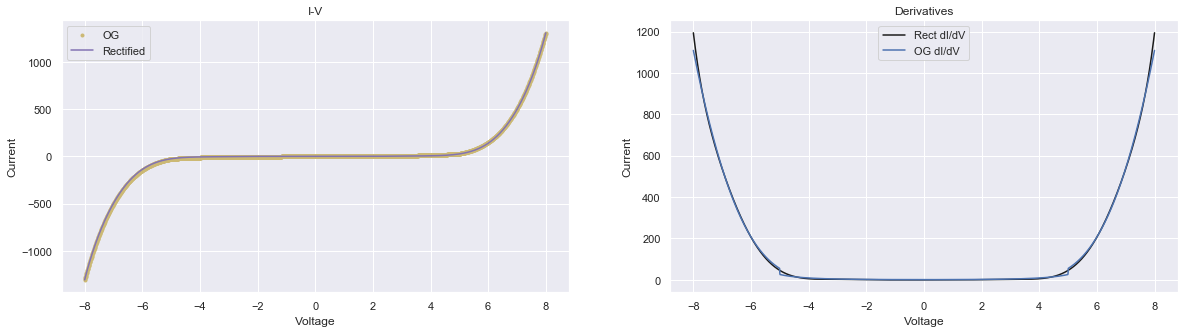

In [36]:
## Simmons Model Example ##

E0 = np.linspace(-8,8,2002)
t=np.linspace(-4,4,2002)

I = current(Simmons = True)
Q = Q_data(t=t, V=signal, I=I, E0=E0) # generate rectified Q data
rec = rectify(V=signal, Q=Q , E0=E0 , t=t, fit_terms=12) # rectify current


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))

ax1.plot(E0,I.calculate(E0), 'y.', label = "OG")
ax1.set_title('I-V')
ax1.set_xlabel("Voltage")
ax1.set_ylabel('Current')
ax1.plot(E0,rec[0],'m-', label='Rectified')
ax1.legend()


ax2.plot(E0[:-1], np.diff(rec[0])/np.diff(E0), 'k', label='Rect dI/dV')
ax2.plot(E0[:-1], np.diff(I.calculate(E0))/np.diff(E0), label="OG dI/dV")
ax2.set_title('Derivatives')
ax2.set_xlabel("Voltage")
ax2.set_ylabel('Current')
ax2.legend()